# Notebook n°2: Classification de modèles de voitures
### Source : voir partie "Modèle"

## 1) Importation des librairies

In [1]:
import numpy as np
import pandas as pd
import os

from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU
import cv2
from tqdm import tqdm
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import seaborn as sns

from zipfile import ZipFile

## 2) Monture de Google Colab et décompression du dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
with ZipFile('/content/drive/MyDrive/Standford_Car_dataset.zip', 'r') as zipObj:
  zipObj.extractall()

## 3) Exploration des données

In [4]:
def convert_to_csv(path):
  data_dict = {
    'img_path': [], 
    'label': [],  
  }

  for (dir_path, dir_names, file_names) in os.walk(path):
    
    for file_name in file_names:
      data_dict['img_path'].append(dir_path + '/' + file_name)
      data_dict['label'].append(dir_path.split('/')[-1])
 
  df = pd.DataFrame.from_dict(data_dict)
  df.to_csv("data_dict.csv", index=False)

path = "./Standford_Car_dataset/car_data/"
convert_to_csv(path)

In [5]:
EPOCHS = 40
BATCH_SIZE = 32

In [6]:
dataframe = pd.read_csv('data_dict.csv')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


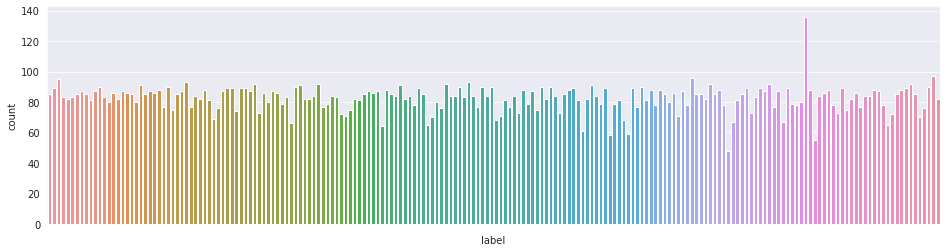

In [7]:
plt.figure(figsize=(16,4))

sns.set_style('darkgrid')
ax = sns.countplot(dataframe['label']) 
ax.set(xticklabels=[])
plt.show()

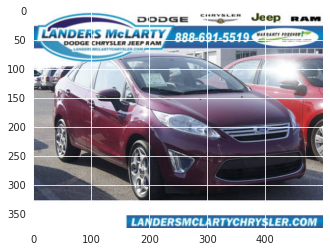

In [8]:
img = cv2.imread(dataframe['img_path'][0])
plt.imshow(img[:, :, ::-1])

In [9]:
names_df = pd.read_csv('/content/Standford_Car_dataset/names.csv', header=None, names=["classes"])
classes = names_df["classes"].tolist()
len(classes)

196

## 4) Générateur de données + augmentation

In [10]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df, classes,
                 batch_size = 32,
                 input_size=(160, 160),
                 shuffle=True,
                 data_augmentation = False):
        
        self.df = df
        self.classes = classes
        self.batch_size = batch_size
        self.input_size = input_size
        self.data_augmentation = data_augmentation
        self.var = 1
        
        self.imageGenerator = ImageDataGenerator(
            horizontal_flip = True,
            #vertical_flip = True,
            fill_mode = 'nearest',
            zoom_range = (1, 1.1),
            width_shift_range = 0.1,
            height_shift_range = 0.1,
            rotation_range = 10
        )
        
        self.images = []
        self.labels = []        
        
        for index, row in tqdm(df.iterrows()):
            img = cv2.imread(row['img_path'])
            img = cv2.resize(img, input_size)
            self.images.append(img)
            self.labels.append(self.classes.index(row['label']))
            
        self.images = np.array(self.images).astype(np.int32)
        self.labels = np.array(self.labels).astype(np.float32)
        
        p = np.random.permutation(len(self.labels))

        self.images = self.images[p]
        self.labels = to_categorical(self.labels[p], num_classes=len(self.classes))

        self.n = len(self.df)
        
    
    def __getitem__(self, index):
        images = []
        
        for i in range(self.batch_size):
            image = self.images[index * self.batch_size + i]
            
            if self.data_augmentation:                
                image = self.imageGenerator.random_transform(image)
                
            images.append(image)
            
        s = slice(self.batch_size * index, (index + 1) * self.batch_size)
        return np.array(images), self.labels[s]
    

    def __len__(self):
        return self.n // self.batch_size
    

    def on_epoch_end(self):
        #Random permutation
        p = np.random.permutation(len(self.labels))
        self.images = self.images[p]
        self.labels = self.labels[p]

## 5) Création des jeux d'entraînement, de validation et de test (80/10/10)

In [11]:
#Divide into train and validation
w_train, w_val, w_test = 0.8, 0.1, 0.1

choices = random.choices(population=[0, 1, 2], weights=[w_train, w_val, w_test], k=len(dataframe))

msk_train = np.array([choice==0 for choice in choices])
msk_val = np.array([choice==1 for choice in choices])
msk_test = np.array([choice==2 for choice in choices])

train = dataframe[msk_train]
val = dataframe[msk_val]
test = dataframe[msk_test]

train_dataset = CustomDataGen(train, classes, data_augmentation = True)
val_dataset = CustomDataGen(val, classes)
test_dataset = CustomDataGen(test, classes)

12905it [01:35, 135.49it/s]
1684it [00:15, 110.29it/s]
1596it [00:12, 124.64it/s]


251
0.0 0.0 0.0


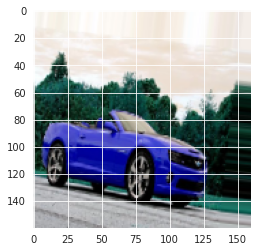

In [12]:
train_dataset.on_epoch_end()
x, y = train_dataset[10]
print(x[21].max())
print(y[0][0], y[1][0], y[2][0])
plt.imshow(x[0])

## 6) Création du modèle

In [13]:
"""
This code is implemented from these of two papers:
- Q. Hu, H. Wang, T. Li and C. Shen, "Deep CNNs With Spatially Weighted Pooling for Fine-Grained Car Recognition," 
in IEEE Transactions on Intelligent Transportation Systems, vol. 18, no. 11, pp. 3147-3156, Nov. 2017, doi: 10.1109/TITS.2017.2679114.
- Yang, L., Luo, P., Loy, C. C., & Tang, X. (2015). A large-scale car dataset for fine-grained categorization and verification. 
2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR). doi:10.1109/cvpr.2015.7299023
"""

import tensorflow as tf

class SWPLayer(tf.keras.layers.Layer):
    def __init__(self, K: int = 9, stddev: float = 0.005, seed: int = None, name: str = None):
        """
          K: Number of masks
          stddev: standard deviation of random normal of weights
          name: custom name for SWP Layer
        """
        super(SWPLayer, self).__init__(name=name)
        self.K = K
        self.stddev = stddev
        self.seed = seed

    def get_config(self):
        return {
            'K': self.K,
            'stddev': self.stddev,
            'seed': self.seed
        }

    def build(self, input_shape):
      super(SWPLayer, self).build(input_shape)

      weight_init = tf.keras.initializers.random_normal(stddev=self.stddev, seed=self.seed)
      mask_shape = (input_shape[1], input_shape[2], self.K)

      self.masks = tf.Variable(initial_value=weight_init(
          shape=(mask_shape),
          dtype='float32'
      ), trainable=True)
    
    def call(self, inputs):
      return tf.einsum('bhwc,hwm->bmc', inputs, self.masks)

In [14]:
"""
This code is implemented from these of two papers:
- Q. Hu, H. Wang, T. Li and C. Shen, "Deep CNNs With Spatially Weighted Pooling for Fine-Grained Car Recognition," 
in IEEE Transactions on Intelligent Transportation Systems, vol. 18, no. 11, pp. 3147-3156, Nov. 2017, doi: 10.1109/TITS.2017.2679114.
- Yang, L., Luo, P., Loy, C. C., & Tang, X. (2015). A large-scale car dataset for fine-grained categorization and verification. 
2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR). doi:10.1109/cvpr.2015.7299023
"""

import tensorflow as tf
from tensorflow.keras.applications import ResNet50, ResNet101, VGG16
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import L2
from tensorflow.keras.initializers import random_normal

class ResNet_SWP(tf.keras.Model):
    def __init__(self,
               base_model: str = 'resnet50',
               base_model_trainable: bool = True,
               #input_shape: tuple = (224, 224, 3),
               input_shape: tuple = (160, 160, 3), #modification de input_shape
               num_classes: int = 431,
               swp_num_of_masks: int = 9,
               fc_nodes: int = 1024,
               weight_decay: float = 0.0005,
               stddev: float = 0.005,
               dropout_ratio: float = 0.5,
               random_state: int =None
               ):
        """
        # ResNet_SWP
        `base_model` (str): resnet50 or resnet101
        `base_model_trainable` (bool): set `base_model` to `trainable`
        `input_shape` (tuple): input shape of images
        `num_classes` (int): number of classes
        `swp_num_of_masks` (int): number of masks of SWP layer
        `fc_nodes` (int): number of nodes of fully-connected layers
        `weight_decay` (float): L2 regularized multiplier
        `stddev` (float): standard deviation of random normal
        `dropout_ratio` (float): ratio of Dropout layer to prevent overfitting problem
        `random_state` (int): set random state for random initialized parameters.
        """
        super(ResNet_SWP, self).__init__()

        # initialize layers
        if base_model == 'resnet50':
            self.base_model = ResNet50(include_top=False, input_shape=input_shape)
        else:
            self.base_model = ResNet101(include_top=False, input_shape=input_shape)
        
        self.base_model.trainable = base_model_trainable

        self.swp_layer = SWPLayer(swp_num_of_masks, seed=random_state)
        self.batch_norm_layer_1 = BatchNormalization()
        self.batch_norm_layer_2 = BatchNormalization()
        self.relu_act_layer_1 = Activation('relu')
        self.relu_act_layer_2 = Activation('relu')
        self.flatten_layer = Flatten()
        self.fc_layer = Dense(fc_nodes, kernel_regularizer=L2(weight_decay),
                            kernel_initializer=random_normal(stddev=stddev, seed=random_state))
        self.dropout_layer = Dropout(dropout_ratio, seed=random_state)
        self.output_layer = Dense(num_classes,
                            kernel_regularizer=L2(weight_decay),
                            activation='softmax')

    def call(self, inputs):
        x = self.base_model(inputs)
        x = self.swp_layer(x)
        x = self.batch_norm_layer_1(x)
        x = self.flatten_layer(x)
        x = self.relu_act_layer_1(x)
        x = self.fc_layer(x)
        x = self.batch_norm_layer_2(x)
        x = self.relu_act_layer_2(x)
        x = self.dropout_layer(x)
        return self.output_layer(x)

In [15]:
model = ResNet_SWP(num_classes=196)

94765736/94765736 [==============================] - 5s 0us/step


## 7) Entraînement du modèle

In [16]:
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4), loss = ['categorical_crossentropy'], metrics = ['accuracy'])

plateau = tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_loss', factor=0.3, patience=2, verbose = 1
)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                                      patience=5)  # Early stopping (stops training when validation doesn't improve for {patience} epochs)

save_best = tf.keras.callbacks.ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True,
                                            mode='min', save_weights_only = True)  # Saves the best version of the model to disk (as measured on the validation data set)

remote_monitor_callback = tf.keras.callbacks.RemoteMonitor(
    root='https://dweet.io', path='/dweet/for/multitask',
    send_as_json=False, field = 'data'
)     

history = model.fit(train_dataset,
            epochs=EPOCHS,
            batch_size = BATCH_SIZE,
            validation_data=val_dataset,
            callbacks = [es, save_best, plateau, remote_monitor_callback])

Epoch 1/40
403/403 [==============================] - 112s 255ms/step - loss: 4.7283 - accuracy: 0.1319 - val_loss: 3.9666 - val_accuracy: 0.2764 - lr: 1.0000e-04
Epoch 2/40
403/403 [==============================] - 102s 251ms/step - loss: 2.7378 - accuracy: 0.4363 - val_loss: 2.2891 - val_accuracy: 0.5228 - lr: 1.0000e-04
Epoch 3/40
403/403 [==============================] - 101s 250ms/step - loss: 1.8410 - accuracy: 0.6366 - val_loss: 1.8113 - val_accuracy: 0.6256 - lr: 1.0000e-04
Epoch 4/40
403/403 [==============================] - 99s 245ms/step - loss: 1.3859 - accuracy: 0.7507 - val_loss: 1.6509 - val_accuracy: 0.6701 - lr: 1.0000e-04
Epoch 5/40
403/403 [==============================] - 102s 252ms/step - loss: 1.1160 - accuracy: 0.8230 - val_loss: 1.4631 - val_accuracy: 0.7079 - lr: 1.0000e-04
Epoch 6/40
403/403 [==============================] - 99s 245ms/step - loss: 0.9418 - accuracy: 0.8634 - val_loss: 1.6334 - val_accuracy: 0.6821 - lr: 1.0000e-04
Epoch 7/40
403/403 [====

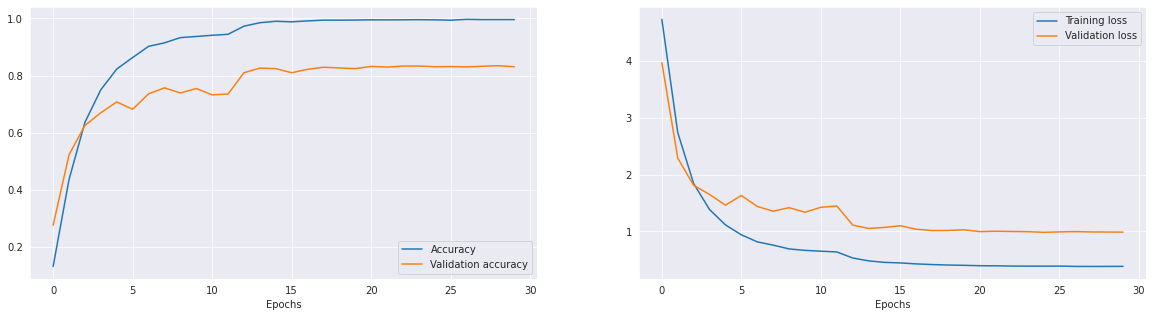

In [18]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(history.history['accuracy'], label='Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()  

    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)

## 8) Evaluation du modèle

In [19]:
model.load_weights('weights.h5')
model.evaluate(test_dataset)

49/49 [==============================] - 4s 69ms/step - loss: 1.0315 - accuracy: 0.8469


[1.031538963317871, 0.8469387888908386]

In [20]:
images, labels = val_dataset[22]
p = model.predict(images)

1/1 [==============================] - 1s 1s/step


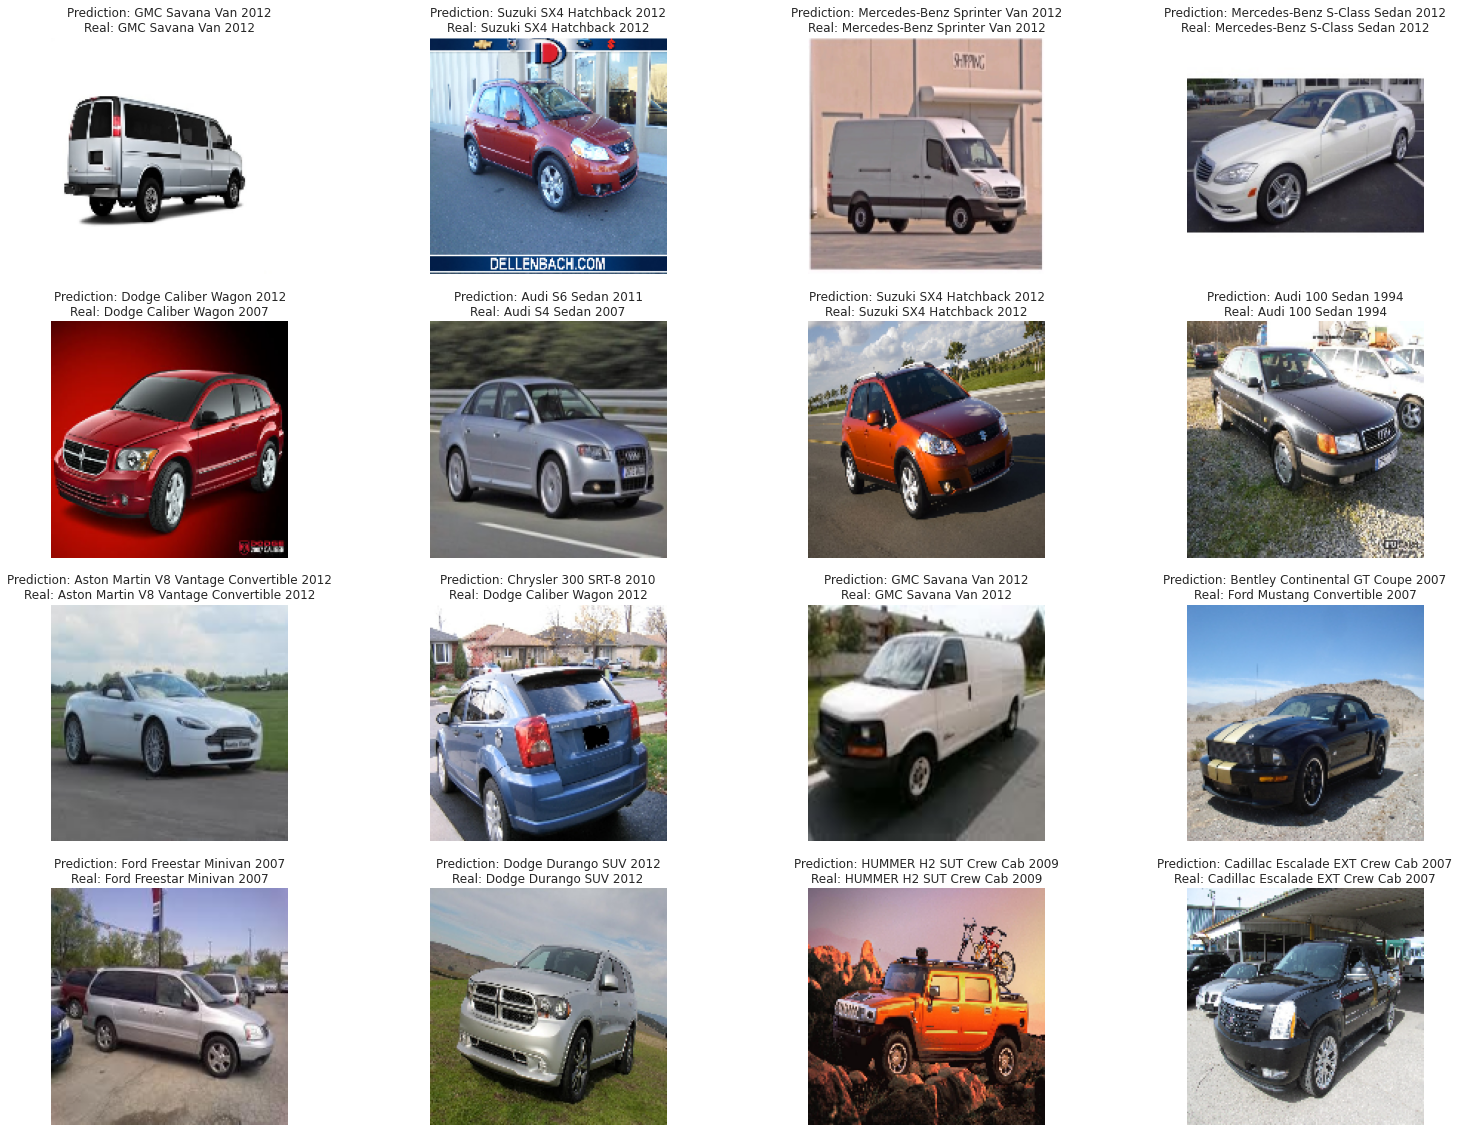

In [22]:
fig, axes = plt.subplots(4, 4, figsize=(26, 20))

for ax in axes.ravel():
    ax.axis("off")
    
for i, ax in enumerate(axes.flat):
    ax = axes.flat[i]
    ax.imshow(images[i][:, :, ::-1], cmap='hsv')
    ax.set_title(f'Prediction: {classes[p[i].argmax()]}\n'+ f'Real: {classes[int(labels[i].argmax())]}')

plt.show()